In [1]:
import torch
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.utils import safe_load_mesh
import pickle
import sys
from models.vae_models import VAE, VAE2, KL_divergence
from models.ghd_reconstruct import GHD_Reconstruct
from models.losses import wgan_gradient_penalty
from torch_geometric.data import Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models.utils import save_models, load_models, plot_wandb
from sklearn.decomposition import PCA
import numpy as np
from pytorch3d.loss import mesh_laplacian_smoothing, mesh_normal_consistency
from visualization.gallery import get_fig, get_fig_advanced
from IPython.display import Image
from models.vae_models import ConditionalVAE4Fouriers


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from models.mesh_plugins import MeshPlugins
from models.vae_datasets import GHDDataset

device = torch.device("cuda:0")
get_gif = False
withscale = True

root = ''
ghd_chk_root = os.path.join(root, 'checkpoints/ghd_fitting')
ghd_run = 'vanilla'
ghd_chk_name = 'ghb_fitting_checkpoint_5.pkl'
alignment_root = os.path.join(root, 'checkpoints/alignment')
canonical_path = os.path.join(root, alignment_root, 'canonical_typeB')
eigen_chk = os.path.join(canonical_path, "canonical_typeB_144.pkl")
canonical_Meshes = safe_load_mesh(os.path.join(canonical_path, 'part_aligned_updated.obj'))
cep_chk = os.path.join(canonical_path, "diff_centreline_checkpoint.pkl")
trimmed_mesh_path = os.path.join(canonical_path, "part_trimmed_short.obj")
wave_based_trimming = False # if True, use wave-based trimming instead of manually registered mask
mesh_plugin = MeshPlugins(canonical_Meshes, cep_chk, trimmed_mesh_path=trimmed_mesh_path, wave_based_trimming=wave_based_trimming)
ghd_reconstruct = GHD_Reconstruct(canonical_Meshes, eigen_chk, num_Basis=12**2, device=device)
cases = [case for case in os.listdir(ghd_chk_root) if os.path.isdir(os.path.join(ghd_chk_root, case)) and case != "canonical_typeB"]
ghd_dataset = GHDDataset(ghd_chk_root, ghd_run, ghd_chk_name, ghd_reconstruct, cases, withscale=withscale, normalize=True)
mean_ghd, std_ghd = ghd_dataset.get_mean_std()
mean_scale, std_scale = ghd_dataset.get_scale_mean_std()
hidden_dim_ghd = 256
latent_dim_ghd = 64

# load GHD VAE
ghd_vae = VAE(ghd_dataset.get_dim(), hidden_dim_ghd, latent_dim_ghd, withscale=withscale).to(device)
ghd_vae_chk = os.path.join("checkpoints/first_stage_unconditional", 'vanilla_withscale', 'models_epoch_{}.pth'.format(9000))
ghd_vae.load_state_dict(torch.load(ghd_vae_chk)['generator'])
ghd_vae.eval()

Skeletonizing: 100%|██████████| 4143/4143 [00:00<00:00, 246025.14it/s]
/home/wenhao/anaconda3/envs/gnn2/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")
/media/yaplab/"HDD Storage"/wenhao/AneuG/models/mesh_plugins.py:683: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cap_tensor = torch.tensor(cap_indices, device=faces.device)


116 cases out of 116 have GHD checkpoint


/home/wenhao/anaconda3/envs/gnn2/lib/python3.8/site-packages/pytorch3d/ops/laplacian_matrices.py:130: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020195/work/torch/csrc/utils/tensor_new.cpp:605.)
  L = torch.sparse.FloatTensor(idx, cot.view(-1), (V, V))


VAE(
  (fc1): Linear(in_features=433, out_features=256, bias=True)
  (res1): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc21): Linear(in_features=256, out_features=64, bias=True)
  (fc22): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=256, bias=True)
  (res2): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (f

In [3]:
from models.vae_datasets import CenterlineDataset
from models.vae_models import CPCDReconstruct

# centerline dataset
cl_chk_root = "./checkpoints/centreline_fitting/stable"
toss_threshold = 0.01
centerline_dataset = CenterlineDataset(cl_chk_root, normalize=True, toss_threshold=toss_threshold, device=device)
num_branch, num_fourier, fourier_per_branch = centerline_dataset.num_branch, centerline_dataset.num_fourier, centerline_dataset.fourier_per_branch
data_loader = DataLoader(centerline_dataset, batch_size=128, shuffle=False)

# cpcd reconstructer
cpcd_reconstruct = CPCDReconstruct(num_branch, num_fourier, fourier_per_branch, device=device)

90 cases have been loaded, 5 cases have been tosses due to bad fitting


In [4]:
# model conf
hidden_dim = 256
latent_dim = 6
basis_include = 12**2
batch_size = 128
mode = 'train'
reload_epoch = 4000
meta = 'h256_l6_withscale'
log_path = os.path.join("./checkpoints/second_stage", meta)
os.makedirs(log_path, exist_ok=True)

cvae = ConditionalVAE4Fouriers(num_branch, num_fourier, fourier_per_branch, num_basis=basis_include,
                               hidden_dim=hidden_dim, latent_dim=latent_dim, dropout=0.0,
                               tangent_encoding=True, ghd_reconstruct=ghd_reconstruct, mesh_plugin=mesh_plugin,
                               cpcd_reconstruct=cpcd_reconstruct, 
                               norm_dict=centerline_dataset.return_norm_dict(device), normalize=True,
                               ghd_encoding=True,
                               withscale=withscale).to(device)

# load model
if reload_epoch is not None:
    chk = torch.load(os.path.join(log_path, 'models_epoch_{}.pth'.format(reload_epoch)))
    cvae.load_state_dict(chk['generator'])
    print("Reloaded from epoch: ", reload_epoch)


Reloaded from epoch:  4000


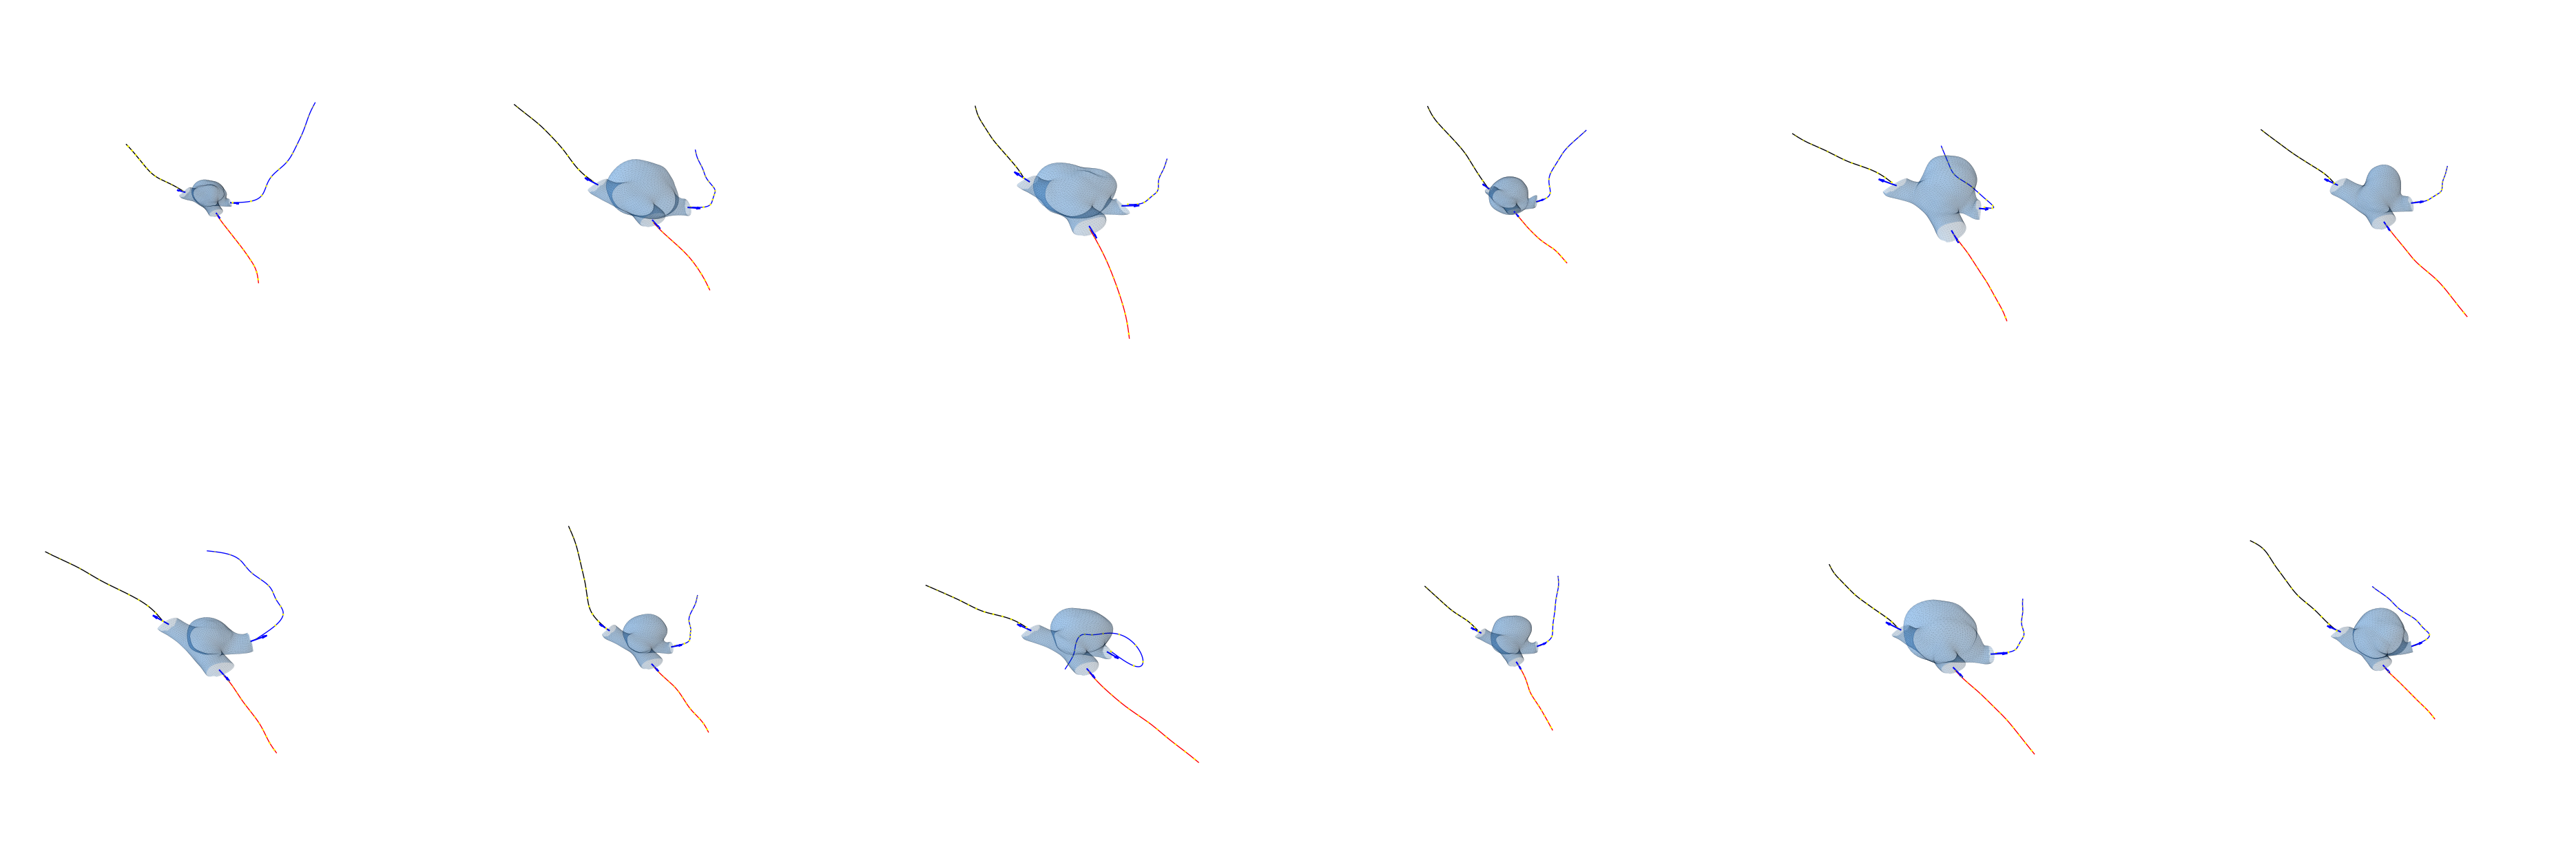

In [5]:
plt.close('all')
# unconditional generation
B = 12
ghd_fake = ghd_vae.decode(torch.randn(B, latent_dim_ghd).to(device))
if withscale:
    ghd_fake, scale_fake = ghd_fake[0], ghd_fake[1]
    scale_fake = scale_fake * std_scale.to(scale_fake.device) + mean_scale.to(scale_fake.device)
else:
    ghd_fake, scale_fake = ghd_fake, None
data_fake = ghd_reconstruct.forward(ghd_fake, mean_ghd, std_ghd, return_norm=True)
if mean_ghd is not None and std_ghd is not None:
    ghd_fake = ghd_fake * std_ghd.to(ghd_fake.device) + mean_ghd.to(ghd_fake.device)
cpcd_glo_gen, cpcd_tangent_glo_gen, tangent_from_ghd = cvae.generate(ghd_fake, scale_fake)

fig_uncon = get_fig_advanced(ghd_reconstruct, data_fake, 6, Title=None, mesh_plugin=mesh_plugin, plot_tangent=True,
                             plot_vessel=True, cpcd_glo=cpcd_glo_gen, sub_size=8, scale=scale_fake)
label="vessel_generation"
plt.show(fig_uncon)

Applying spline connecting: 100%|██████████| 14/14 [00:00<00:00, 535.53it/s]


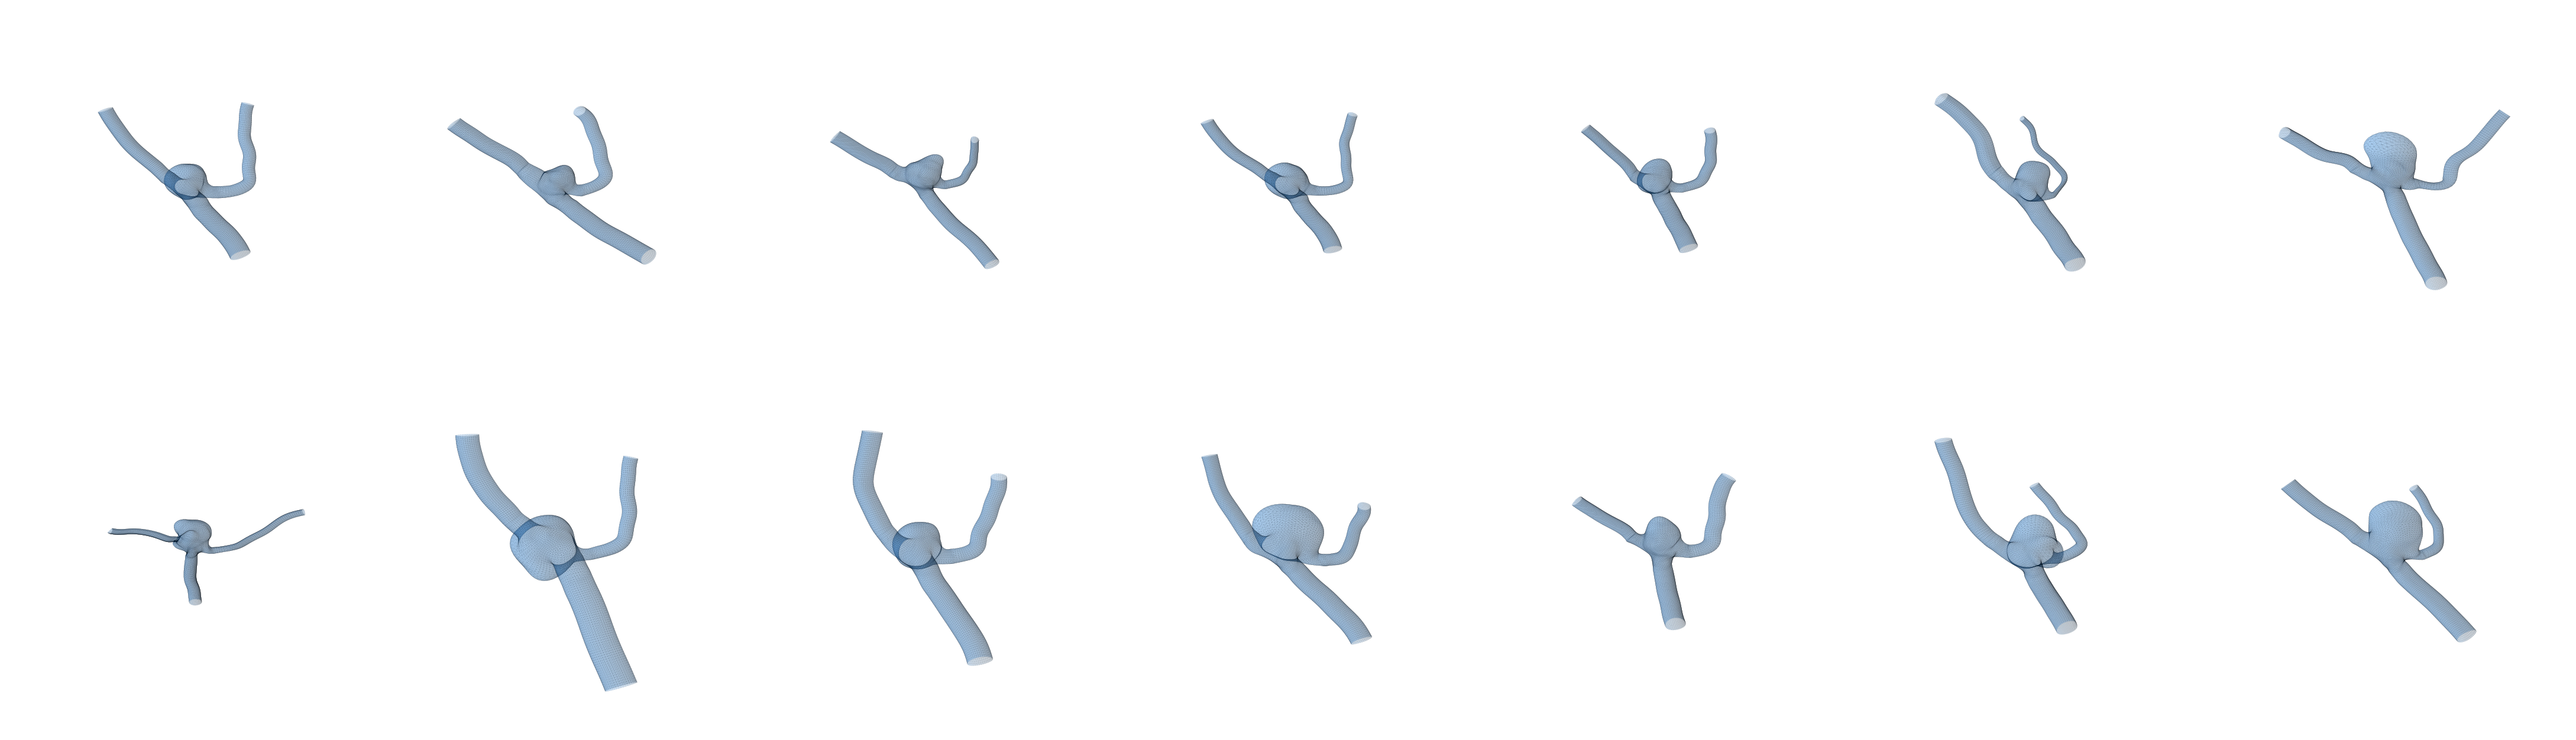

In [ ]:
from models.mesh_plugins import MeshFusion, p3d_to_trimesh
from visualization.gallery import get_fig_mesh_fusion

plt.close('all')
B = 14
ghd_fake = ghd_vae.decode(torch.randn(B, latent_dim_ghd).to(device))
# ghd_fake = (ghd_fake - mean_ghd.to(ghd_fake.device)) / std_ghd.to(ghd_fake.device)
ghd_fake = ghd_vae.decode(torch.randn(B, latent_dim_ghd).to(device))
if withscale:
    ghd_fake, scale_fake = ghd_fake[0], ghd_fake[1]
    scale_fake = scale_fake * std_scale.to(scale_fake.device) + mean_scale.to(scale_fake.device)
else:
    ghd_fake, scale_fake = ghd_fake, None

meshfusion = MeshFusion(ghd_reconstruct=ghd_reconstruct,
                        mean_ghd=mean_ghd, std_ghd=std_ghd,
                        mesh_plugin=mesh_plugin,
                        device=device)

fig_smoothed, merged_mesh_list = get_fig_mesh_fusion(ghd_fake, mean_ghd, std_ghd, 
                                   ghd_reconstruct, cvae,
                                   meshfusion,
                                   column=7, sub_size=8,
                                   connection_smoothing=True,
                                   title_=None,
                                   scale=scale_fake,
                                   control=False,
                                   spline=True,
                                   return_meshes=True)
plt.show(fig_smoothed)